In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/kursovayz')

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from train import x_FrameConc,SaveAndPlot,SaveTrainingLog
from video_processor import VideoReader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
path_add='/content/drive/MyDrive/Colab Notebooks/kursovayz/'
w,h,fps=32,32,15
fn=path_add+'WLASL_v0.3.json'

limit_class='go'
path='corrected names.csv'

# CsvCorrector("C:/Users/Administrator/JUPYTER/kursovayz/raw_videos/*",fn,'testing.csv')

# from video_processor import process
# proc=process(w,h,fps)
# proc.ConvertAllWLASL(path=path,limit_class=limit_class,path_add=path_add,isCanny=False)

In [ ]:
scaler=MinMaxScaler()
label_encoder=LabelEncoder()

_x,_y=VideoReader(path,limit_class=limit_class,path_add=path_add,read_raws=False)
label_encoder.fit(_y)

x,frame_num=x_FrameConc(_x,w,h)
y=label_encoder.transform(_y)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [ ]:
from keras.layers.regularization.dropout import Dropout
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, ConvLSTM2D,Flatten, BatchNormalization, TimeDistributed, Dropout
_loss='sparse_categorical_crossentropy'
kernel_size=(2,2)

model3dlstm=Sequential()
model3dlstm.add(ConvLSTM2D(32,kernel_size,activation='tanh',input_shape=(frame_num,w,h,3),return_sequences=True))
model3dlstm.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model3dlstm.add(BatchNormalization())
model3dlstm.add(ConvLSTM2D(64,kernel_size,activation='tanh',input_shape=(frame_num,w,h,3),return_sequences=True))
model3dlstm.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model3dlstm.add(BatchNormalization())
model3dlstm.add(ConvLSTM2D(128,kernel_size,activation='tanh',input_shape=(frame_num,w,h,3),return_sequences=True))
model3dlstm.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model3dlstm.add(Flatten())
model3dlstm.add(TimeDistributed(Dense(256,activation='relu')))
model3dlstm.add(Dense(6,activation='softmax'))
model3dlstm.compile(optimizer='adam',loss=_loss,metrics=['accuracy'])
model3dlstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 139, 30, 30, 32)   40448     
                                                                 
 time_distributed_2 (TimeDis  (None, 139, 15, 15, 32)  0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 139, 15, 15, 32)  128       
 ormalization)                                                   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 139, 13, 13, 64)   221440    
                                                                 
 time_distributed_3 (TimeDis  (None, 139, 6, 6, 64)    0         
 tributed)                                                       
                                                      

Epoch 1/300
2/2 [==============================] - 17s 5s/step - loss: 5.4334 - accuracy: 0.2667 - val_loss: 2.7989 - val_accuracy: 0.2667
Epoch 2/300
2/2 [==============================] - 6s 3s/step - loss: 7.5176 - accuracy: 0.3000 - val_loss: 5.1915 - val_accuracy: 0.2000
Epoch 3/300
2/2 [==============================] - 7s 4s/step - loss: 14.9090 - accuracy: 0.1500 - val_loss: 12.4414 - val_accuracy: 0.2000
Epoch 4/300
2/2 [==============================] - 6s 3s/step - loss: 7.4739 - accuracy: 0.2000 - val_loss: 3.0538 - val_accuracy: 0.2000
Epoch 5/300
2/2 [==============================] - 8s 5s/step - loss: 11.3786 - accuracy: 0.3333 - val_loss: 5.2446 - val_accuracy: 0.2000
Epoch 6/300
2/2 [==============================] - 5s 3s/step - loss: 10.4531 - accuracy: 0.2667 - val_loss: 3.6559 - val_accuracy: 0.2000
Epoch 7/300
2/2 [==============================] - 7s 5s/step - loss: 2.8452 - accuracy: 0.3667 - val_loss: 3.5770 - val_accuracy: 0.2000
Epoch 8/300
2/2 [============

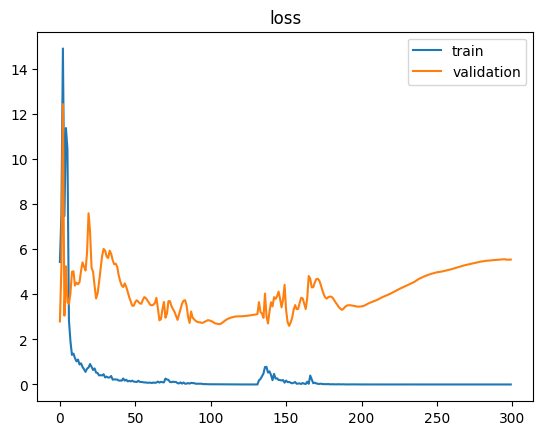

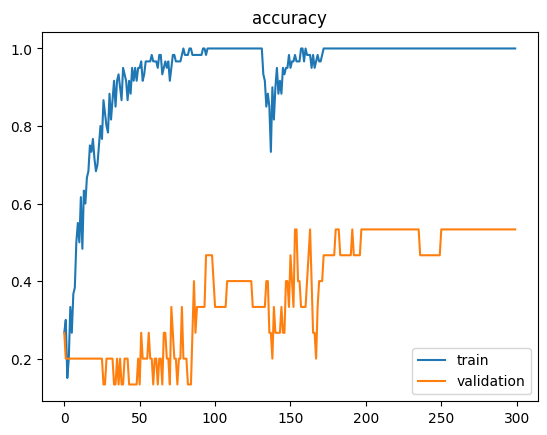

In [ ]:
_epochs=300
history=model3dlstm.fit(x_train,y_train,epochs=_epochs,validation_data=(x_test,y_test))

SaveTrainingLog(model3dlstm,history)
SaveAndPlot(history)

# model3d.evaluate(x_test,y_test)